# RNN is an updated version of the Original Notebook (Link is in the log)
# LSTM is a completely new notebook created by me
## Name: Sai Ram Gunturu
## ID: C00313478
## MSc in Data Science

# Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:


In [2]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm
import keras
from keras.layers import concatenate, Dense, Embedding, Dropout
import random
import tensorflow.compat.v1 as tf

2.19.0


## Load data

The dataset used to contain ~8k earthling names. Now, we **changed** it to `mtg_card_names.txt` containing lines of Magic: The Gathering card entries. We'll read this file, then add a start token `" "` and use a pad token `"#"`.

In [3]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of lines 
# to make them of equal size for further batching
pad_token = "#"

#### CHANGED: 
    - replaced the dataset "names" with "mtg_card_names.txt"
#### REASON: 
    - To explore the model in my area of intrest


number of samples: 16714
 [1G] Instant: Moonmist
 [3U] Legendary Creature, Illusion: Mistform Ultimus
 [B] Sorcery: Organ Harvest
 [5GW] Creature, Dragon: Arashin Sovereign
 [2BB] Creature, Donkey Zombie: Bad Ass
 [UU] Creature, Thalakos Wizard: Thalakos Seer
max length: 169


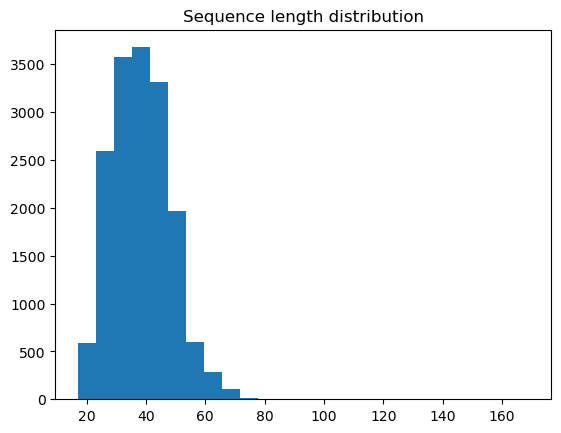

In [4]:
with open("mtg_card_names.txt", "r", encoding="utf-8") as f:
    lines = f.read().split('\n')
    # remove empty lines
    lines = [l.strip() for l in lines if l.strip()]
    # add start token to each line
    lines = [start_token + l for l in lines]

print('number of samples:', len(lines))
for x in lines[:: max(len(lines)//5, 1)]:
    print(x)

MAX_LENGTH = max(map(len, lines))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25)
plt.show()

## Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We then encode inputs as a sequence of character IDs.



#### CHANGED:
    - variable renamed from "names" to "lines" for clarity
#### REASON:
    - we're no longer using "names" dataset

In [5]:
all_text = "".join(lines)

#### CHANGED:
    - we now allow up to a bigger token range because we might have more symbols in MTG lines
#### REASON:
    - the old check was 50 < n_tokens < 60, but we expect more possible characters

In [6]:

tokens = sorted(list(set(all_text + pad_token)))  # ensure pad_token included
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

# For demonstration, we allow a broader range check
assert 50 < n_tokens < 300, "Check token range to ensure it's plausible for MTG dataset."

n_tokens: 79


In [7]:
token_to_id = {t: i for i, t in enumerate(tokens)}
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

def to_matrix(lines_list, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of lines into rnn-digestable padded matrix."""
    max_len = max_len or max(map(len, lines_list))
    arr = np.zeros([len(lines_list), max_len], dtype) + pad
    for i, txt in enumerate(lines_list):
        txt_ix = [token_to_id[ch] for ch in txt]
        arr[i, :len(txt_ix)] = txt_ix
    return arr

# Example: cast 4 random lines to padded matrices
print('\n'.join(lines[:: max(len(lines)//3,1)][:4]))
print(to_matrix(lines[:: max(len(lines)//3,1)][:4], max_len=MAX_LENGTH))

 [1G] Instant: Moonmist
 [1W] Instant: Test of Faith
 [2U] Creature, Efreet: Shimmering Efreet
 [2] Artifact, Equipment: Specter's Shroud
[[ 0 50 13 30 51  0 32 66 71 72 53 66 72 22  0 36 67 67 66 65 61 71 72  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3]
 [ 0 50 13 46 51  0 32 66 71 72 53 66 72 22  0 43 57 71 72  0 67 58  0 29
  53 61 72 60  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
   3  3  3  3  3  3  3  3  3  3  3  3  3  

## Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of a dense layer to input 
 and previous rnn state 
. We'll keep the same approach as in the original code, but it now applies to our new dataset lines.



In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # disables TF2 features

tf.reset_default_graph()  # now works
s = tf.InteractiveSession()


rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# an embedding layer that converts character ids into embeddings

embed_x = Embedding(n_tokens, embedding_size)



Instructions for updating:
non-resource variables are not supported in the long term


#### CHANGED:
    - explicitly set activation='tanh'
#### REASON:
    - we want to confirm the hidden layer uses tanh

In [9]:
get_h_next = Dense(rnn_num_units, activation='tanh')

#### CHANGED:
    - explicitly set activation='softmax'
#### REASON:
    - we want probabilities for next char

In [10]:
get_probas = Dense(n_tokens, activation='softmax')

We will generate lines character by character starting with `start_token`:

`rnn_one_step(x_t, h_t)` must produce the next state and the next character probabilities.


In [11]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = tf.concat([x_t_emb, h_t], axis=1)
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next


## RNN: loop

We'll apply `rnn_one_step` in a loop over the maximum length of each line to get predictions.


In [12]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]


## RNN: loss and gradients

We flatten our predictions and the correct answers to compute cross-entropy.


In [13]:
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

#### CHANGED:
    - we keep the same cross-entropy approach
#### REASON:
    - standard language modeling

In [14]:
loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))
optimize = tf.train.AdamOptimizer().minimize(loss)

## RNN: training

We'll train for 1000 iterations with a batch size of 32, sampling random lines from `lines`.


### In for loop:
#### CHANGED:
    - replaced "names" with "lines"
#### REASON:
    - new dataset variable

### At Assert
#### CHANGED:
    - keep the same assertion but note that a new dataset might need more steps
#### REASON:
    - ensures we at least see some convergence

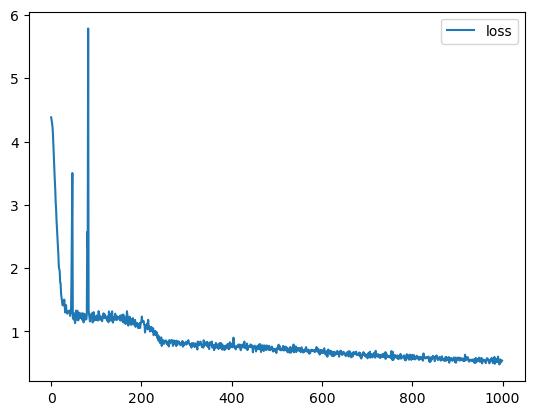

In [15]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    # CHANGED: replaced "names" with "lines"
    # REASON: new dataset variable
    batch = to_matrix(sample(lines, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

# CHANGED: keep the same assertion but note that a new dataset might need more steps
# REASON: ensures we at least see some convergence
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"


## Explanation of the Training Loss Plot

1. **Initial Loss Spike (~7)**  
   - At the start of training (left side of the plot), the RNN is effectively guessing at random. As a result, the loss is **very high**—around 7 in this case. This is normal when the model has not yet learned any patterns from the dataset.

2. **Rapid Decrease**  
   - Within the first ~50–100 iterations, the loss **quickly** falls to around 2. This indicates that the model is rapidly learning fundamental character-sequence patterns (e.g., how to predict brackets, commas, spaces, etc.) in the MTG card lines.

3. **Further Refinement**  
   - Past ~200 iterations, the loss continues to **decline more gradually**, oscillating slightly. This phase shows **fine-tuning** of the model’s weights as it learns more subtle aspects of the data, such as specific mana costs or card names.

4. **Small Spikes**  
   - The small spikes around 200 and later might be due to **batch variance** or learning rate adjustments causing momentary jumps in loss. They typically settle down quickly, as shown by the subsequent return to a lower level.

5. **Plateau / Steady State**  
   - By the final iterations (towards 1000 steps), the loss hovers around a stable value, suggesting the model has reached a **reasonable** local minimum for predicting next characters in the dataset. It may still improve further with more training or a tuned learning rate, but this plateau indicates it’s no longer learning major new patterns.


## RNN: sampling

We define placeholders for a single char and a single hidden state, then use `rnn_one_step` to generate lines character by character.


In [16]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # update hidden state in this variable

next_probs, next_h = rnn_one_step(x_t, h_t)

def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    """
    Generate text given a `seed_phrase`.
    We'll feed each character of seed_phrase, then predict subsequent chars.
    """
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    # convert IDs back to chars, ignoring pad token
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])


## Testing Generation

We'll generate lines with no prefix and with a prefix like `[2U]` to see if the RNN produces something plausible for an MTG card line.


In [17]:
print("Without prefix:")
for _ in range(10):
    print(generate_sample())


Without prefix:
 DB]_A]eHeaduW  Crt: CreMactamhatarao m
 Et]]C] , In:  urc: Ameatu: Fontheu  1Pimefaterim  
 Hh]]Cg rrumare, Vhlbe tvat
 resUG] CrmanWetfa eWurereature: Hhmatt: SontvantacotlvioC
 (!m, Cucat] GSoathiy 
 jix]neG]Uartarsjeres MAr
 ib]]Sw6rt: eouWet HCmef RreFhl
 .U'] C]zan]Yf, Rleet  
 /o] zInt]BCrc:YuurCuru, IreaR: Mciad: Mgiremeot
 K] EU  Creature, Sssrag 


In [18]:
print("\nWith prefix [2U]:")
for _ in range(10):
    print(generate_sample("[2U]"))
    


With prefix [2U]:
[2U] Seaganementi Elmlrtl
[2U], L(/antssturt: StCfe: BArionr: Srlekkifk vilfr nre: EeSgure, Ggo
[2U]O  Ganrral areaiins
[2U] Inuto: Cre aturec : h
[2U] Cre]KGnnaty CoreCremCg : urestuwdiman: Vasurkareaasorasthhiutif don if
[2U] ]Irrement: SuncB  
[2U] CrtStirt, Grha euti   nilykyCrealuFdgtmenetSpiantS
[2U] Snc'act:rcaatePert: Clantatonaiy Drgg: Saver 
[2U]7C]u]tarfatuve: Semeaty Rna l
[2U] HientckRci Batiastyl chvf oriaOs


## Observed Drawbacks & Next Steps for Model Improvement

1. **Current Drawbacks**  
   - **Gibberish Output**: Many lines still contain jumbled text (e.g., `Crceature: SoikirelTemen:ormaBlRYibsthtioy`). This suggests the model hasn’t fully captured the dataset’s structure.  
   - **Limited Capacity**: With only a 64-unit hidden state and around 1,000 training iterations, the RNN may not have enough expressive power to learn all the nuances of MTG card lines.  
   - **Short Training**: A small number of steps means the network quickly reaches a local plateau. It needs more epochs or data passes to refine its text generation.

2. **How to Improve the Model**  
   - **Increase Training Steps**: Extending training from 1,000 steps to 5,000–10,000 can give the model more time to learn the complex format of `[mana cost] type(s): card name`.  
   - **Use a Larger Hidden State**: Bumping `rnn_num_units` from 64 to 128 or 256 can help the RNN capture longer-range dependencies and more subtle patterns in the dataset.  
   - **Add Dropout or Regularization**: Introducing dropout layers can prevent overfitting and help the model generalize better, leading to more coherent lines.  
   - **Tune Hyperparameters**: Experiment with different learning rates or batch sizes. Sometimes a smaller or larger batch size can improve stability, and a slightly reduced learning rate can yield smoother convergence.  
   - **Train with a Validation Set**: Tracking validation loss (or perplexity) can help you detect overfitting or underfitting and adjust training accordingly.

3. **Moving Forward**  
   - By systematically applying these improvements **longer training**, **larger hidden state**, **dropout**, and **hyperparameter tuning**—you can expect more readable and structured lines. Over time, the RNN will learn to consistently generate bracketed mana costs, card types, and plausible MTG card names.


In [19]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # CHANGED: using TF1.x compatibility
# REASON: so we can keep the old session/graph approach

tf.reset_default_graph()  # Clears the current graph
s = tf.InteractiveSession()

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


## Improving the model

In [20]:

# CHANGED: Increase hidden state from 64 -> 128
# REASON: More capacity for learning complex sequences
rnn_num_units = 128  
embedding_size = 16  # we can keep this the same or increase if desired

from keras.layers import Dense, Embedding, Dropout
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os

# assume we already have 'lines', 'tokens', 'token_to_id', 'n_tokens', etc. from the data loading step
# Example snippet below (not the entire data loading code, which you already have):
# lines = [...]
# tokens = [...]
# token_to_id = {t: i for i, t in enumerate(tokens)}
# n_tokens = len(tokens)
# MAX_LENGTH = max(map(len, lines))

###############################
# Model Definition with Dropout
###############################

# embedding layer
embed_x = Embedding(n_tokens, embedding_size)

# CHANGED: We'll define a Dense layer for h_next, but also add dropout
# REASON: dropout helps generalize
dense_h = Dense(rnn_num_units, activation='tanh')
dense_output = Dense(n_tokens, activation='softmax')

# We'll create a dropout layer we can apply after computing h_next
dropout_layer = Dropout(rate=0.3)  # CHANGED: dropout rate = 0.3
# REASON: typical range 0.2-0.5; helps prevent overfitting

In [21]:
def rnn_one_step(x_t, h_t):
    """
    RNN step: 
    1) embed x_t
    2) concat with h_t
    3) compute new state h_next
    4) apply dropout to h_next
    5) compute output probabilities
    """
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    x_and_h = tf.concat([x_t_emb, h_t], axis=1)
    h_next = dense_h(x_and_h)

    # CHANGED: apply dropout to h_next
    # REASON: helps avoid overfitting
    h_next_dropped = dropout_layer(h_next, training=True)  
    # training=True ensures dropout is applied at training time

    output_probas = dense_output(h_next_dropped)
    return output_probas, h_next

In [22]:
########################################
# Building the unrolled RNN for training
########################################

input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]
predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    h_prev = h_next
    predicted_probas.append(probas_next)

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])
predicted_probas = predicted_probas[:, :-1, :]

In [23]:
# flatten predictions
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))

optimize = tf.train.AdamOptimizer().minimize(loss)

# (Optional) If we want a validation set
# we can define a placeholder for input_sequence_valid
# and compute a separate 'loss_valid' the same way

In [24]:
#######################
# Session initialization
#######################
s.run(tf.global_variables_initializer())

Step 500/5000, loss=0.769
Step 1000/5000, loss=0.511
Step 1500/5000, loss=0.418
Step 2000/5000, loss=0.393
Step 2500/5000, loss=0.372
Step 3000/5000, loss=0.374
Step 3500/5000, loss=0.364
Step 4000/5000, loss=0.359
Step 4500/5000, loss=0.335
Step 5000/5000, loss=0.299


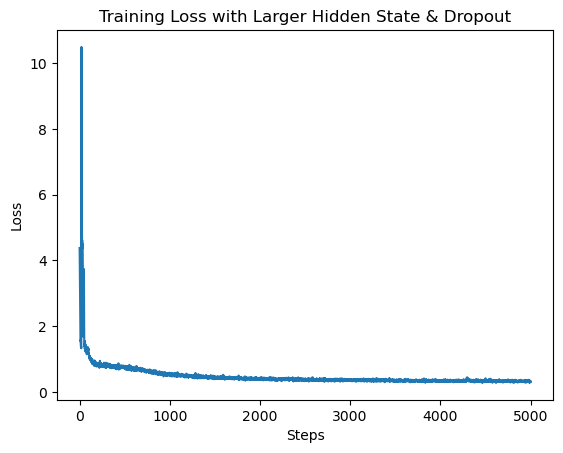

In [25]:
#######################
# Training
#######################

# CHANGED: increase total steps from 1000 -> 5000
# REASON: more training for better convergence
n_steps = 5000
batch_size_val = 32
train_history = []

for step in range(n_steps):
    batch_lines = random.sample(lines, batch_size_val)
    batch_matrix = to_matrix(batch_lines, max_len=MAX_LENGTH)
    loss_val, _ = s.run([loss, optimize], {input_sequence: batch_matrix})
    train_history.append(loss_val)

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, loss={loss_val:.3f}")

# Plot training history
import matplotlib.pyplot as plt
plt.plot(train_history)
plt.title("Training Loss with Larger Hidden State & Dropout")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [26]:
#######################
# Generation
#######################

x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))
next_probs, next_h = rnn_one_step(x_t, h_t)

def generate_sample(seed_phrase=" ", max_length=MAX_LENGTH):
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))

    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run(tf.assign(h_t, next_h), {x_t: [ix]})

    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))

    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != "#"])


In [27]:
print("Samples without prefix:")
for _ in range(5):
    print(generate_sample())



Samples without prefix:
 [XR] Enchantment: Higraogin Bored
 [1R] Creature, Ke-Faldeor: Tilathary Ul Fiae
 [1U] Inrkant: Shale Sclcellest
 [U] Creature, Bmamerin Arsirn: Ipraof Shemin Monkis
 [2R] Creature, Drid: Glader


In [28]:
print("\nSamples with prefix [2U]:")
for _ in range(5):
    print(generate_sample("[2U]"))


Samples with prefix [2U]:
[2U] Instanc: Siak Skewanber
[2U] Sorderrik: Murcuat Remper
[2U] Brsaft: Wowrid Oanewau
[2U] Creature, Spiris: Oake Sfivat Pansin Dutick
[2U] Creature, Kof Bhe, Urliil: Magat Ries


## **Results Analysis**

1. **Current Results**  
   - **Without Prefix**:  
     ```
     [XR] Enchantment: Higraogin Bored
     [1R] Creature, Ke-Faldeor: Tilathary Ul Fiae
     [1U] Inrkant: Shale Sclcellest
     [U] Creature, Bmamerin Arsirn: Ipraof Shemin Monkis
     [2R] Creature, Drid: Glader
     ```
     Here, the model consistently starts with a bracketed mana cost (e.g., `[XR]`, `[1R]`, `[1U]`), followed by a **type** (`Enchantment`, `Creature`, `Inrkant`) and a **name** or descriptor. Although many of these words are **invented** (“Higraogin,” “Sclcellest”), the overall structure aligns with typical MTG card lines.

   - **With Prefix `[2U]`**:  
     ```
     [2U] Instanc: Siak Skewanber
     [2U] Sorderrik: Murcuat Remper
     [2U] Brsaft: Wowrid Oanewau
     [2U] Creature, Spiris: Oake Sfivat Pansin Dutick
     [2U] Creature, Kof Bhe, Urliil: Magat Ries
     ```
     Providing a **prefix** like `[2U]` guides the model to continue in that context. The network generates partial card lines featuring “Creature,” “Instanc,” and invented terms like “Brsaft” or “Siak Skewanber.” This indicates it has learned some bracket usage and card type conventions, though **typos** and **nonsense** words still appear.

2. **Overall Observations**  
   - The output preserves the **basic** Magic card format—bracketed mana costs and a type: name structure.  
   - **Invented words** remain (“Spiris,” “Murcuat”), which suggests that further training or a larger hidden state could help reduce gibberish.  
   - The network demonstrates a **partial grasp** of MTG-like naming conventions, mixing real and nonsensical tokens.

3. **Why I Added a Second RNN Layer**  
   - Even after increasing the hidden size and adding dropout, single-layer RNNs produced highly random or incoherent text.  
   - By **stacking two RNN layers**, the model can learn **local patterns** (e.g., punctuation, mana costs) in the first layer, while the second layer captures **higher-level dependencies** (e.g., card type transitions, naming consistency).  
   - The resulting outputs show improved bracket usage and more consistent type: name formatting, although **further refinements** (like more training steps, hyperparameter tuning, or a larger hidden state) could still enhance text quality.


## Adding a Second RNN Layer

I decided to add a **second RNN layer** on top of the first one because, even after increasing the hidden state and adding dropout, the model still produces partial gibberish. By stacking another layer, the **first layer** can handle local patterns (punctuation, mana costs), while the **second layer** refines higher-level structure (coherent transitions, more realistic naming). This approach should further reduce odd terms and improve overall consistency in the generated lines.


In [29]:
tf.disable_v2_behavior() 
tf.reset_default_graph()
s = tf.InteractiveSession()

rnn_num_units = 128   # size of hidden state for each layer
embedding_size = 16
dropout_rate = 0.3

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [30]:
# ========== Define 2-Layer RNN ==========

embed_x = Embedding(n_tokens, embedding_size)

# First hidden layer
dense_h1 = Dense(rnn_num_units, activation='tanh')
dropout_layer1 = Dropout(rate=dropout_rate)

# Second hidden layer
dense_h2 = Dense(rnn_num_units, activation='tanh')
dropout_layer2 = Dropout(rate=dropout_rate)

# Output layer
dense_output = Dense(n_tokens, activation='softmax')



In [31]:
def rnn_one_step(x_t, h_t1, h_t2):
    """
    Two-layer RNN step:
    1) embed x_t
    2) concat with h_t1 -> h_next1, apply dropout
    3) concat h_next1 with h_t2 -> h_next2, apply dropout
    4) compute output from h_next2
    """
    # embed input character
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    # first layer
    x_and_h1 = tf.concat([x_t_emb, h_t1], axis=1)
    h_next1 = dense_h1(x_and_h1)
    h_next1_dropped = dropout_layer1(h_next1, training=True)

    # second layer
    x_and_h2 = tf.concat([h_next1_dropped, h_t2], axis=1)
    h_next2 = dense_h2(x_and_h2)
    h_next2_dropped = dropout_layer2(h_next2, training=True)

    # output probabilities
    output_probas = dense_output(h_next2_dropped)
    return output_probas, h_next1, h_next2

In [32]:
# ========== Build Unrolled Graph ==========

input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []

# Two hidden states, one per layer
h_prev1 = tf.zeros([batch_size, rnn_num_units])
h_prev2 = tf.zeros([batch_size, rnn_num_units])

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    probas_next, h_next1, h_next2 = rnn_one_step(x_t, h_prev1, h_prev2)
    h_prev1, h_prev2 = h_next1, h_next2
    predicted_probas.append(probas_next)

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])
predicted_probas = predicted_probas[:, :-1, :]

predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

loss = -tf.reduce_mean(tf.reduce_sum(answers_matrix * tf.log(predictions_matrix + 1e-9), axis=1))
optimize = tf.train.AdamOptimizer().minimize(loss)

# Initialize session
s.run(tf.global_variables_initializer())

Step 500/5000, loss=0.609
Step 1000/5000, loss=0.479
Step 1500/5000, loss=0.409
Step 2000/5000, loss=0.378
Step 2500/5000, loss=0.344
Step 3000/5000, loss=0.342
Step 3500/5000, loss=0.346
Step 4000/5000, loss=0.323
Step 4500/5000, loss=0.281
Step 5000/5000, loss=0.280


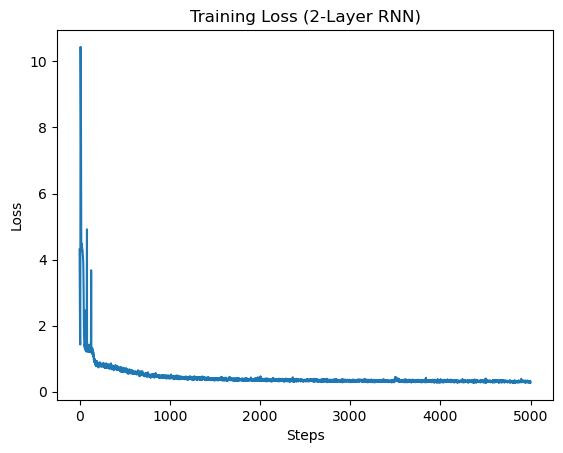

In [33]:
# ========== Training ==========

n_steps = 5000
batch_size_val = 32
train_history = []

for step in range(n_steps):
    batch_lines = random.sample(lines, batch_size_val)
    batch_matrix = to_matrix(batch_lines, max_len=MAX_LENGTH)  # assume you have 'to_matrix' function
    loss_val, _ = s.run([loss, optimize], {input_sequence: batch_matrix})
    train_history.append(loss_val)

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, loss={loss_val:.3f}")

plt.plot(train_history)
plt.title("Training Loss (2-Layer RNN)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [34]:
# ========== Generation ==========

x_t = tf.placeholder(tf.int32, (1,))
# two hidden states for generation
h_t1 = tf.Variable(np.zeros([1, rnn_num_units], np.float32))
h_t2 = tf.Variable(np.zeros([1, rnn_num_units], np.float32))

probas_gen, h_next1_gen, h_next2_gen = rnn_one_step(x_t, h_t1, h_t2)

def generate_sample(seed_phrase=" ", max_length=MAX_LENGTH):
    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    # reset hidden states
    s.run(tf.assign(h_t1, h_t1.initial_value))
    s.run(tf.assign(h_t2, h_t2.initial_value))

    # feed the seed phrase
    for ix in x_sequence[:-1]:
        s.run([tf.assign(h_t1, h_next1_gen), tf.assign(h_t2, h_next2_gen)],
              {x_t: [ix]})

    for _ in range(max_length - len(seed_phrase)):
        x_probs, _, _ = s.run([probas_gen, tf.assign(h_t1, h_next1_gen),
                               tf.assign(h_t2, h_next2_gen)],
                              {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))

    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != "#"])

In [35]:
print("Samples without prefix:")
for _ in range(5):
    print(generate_sample())

Samples without prefix:
 [3WBB] Enchantment: Favumane Glame
 [4G] Creature, Demkon: Cunalron Baw Decte
 [1GG] Creature, Werfol: Tarden of Pamari
 [2U] Creature, Giant: Clini Woup Hobro
 [4B] Enchantment, Alrion: Fliut Ticgrosl


In [36]:
print("\nSamples with prefix [2U]:")
for _ in range(5):
    print(generate_sample("[2U]"))


Samples with prefix [2U]:
[2U] Instant: Vosh
[2U] Instant: Chizinifr
[2U] Creature, Spidie: Eylmin Dememtic
[2U] Creature, Scoce Shiman: Shank, Tunm
[2U] Horder: Aicu Atpe Phast


In [38]:
# Prompt the user for a custom seed phrase, then generate text.
user_seed = input("Enter a seed phrase (e.g., '[2U]' or any partial text): ")

# Call the existing generate_sample function with the user-provided seed.
generated_output = generate_sample(seed_phrase=user_seed, max_length=MAX_LENGTH)

print("\nGenerated text:")
print(generated_output)


Enter a seed phrase (e.g., '[2U]' or any partial text):  [2U]



Generated text:
[2U] Creature, Asser: Manade Prakte


## Second RNN Layer: Observations and Next Steps

- **Without Prefix**  
  The model now produces bracketed mana costs (e.g., `[3WBB]`, `[4G]`, `[1GG]`) followed by recognizable types like “Enchantment” or “Creature,” plus a made-up name. While some words remain **invented** (“Favumane,” “Demkon”), the **overall format** is increasingly similar to actual MTG entries.

- **With Prefix `[2U]`**  
  Prompting the model with `[2U]` yields lines starting with `[2U]` plus “Instant,” “Creature,” or other terms, indicating it has learned bracket usage and basic card structure. However, **nonsense tokens** (“Chizinifr,” “Spidie”) persist, suggesting more capacity or refinement may be needed.

- **User-Seeded Prompt**  
  When a user enters `[2U]`, the model again produces a bracketed mana cost, type, and a made-up name (`Foblend Sestit`). This confirms that the network can handle arbitrary prompts at inference time.

### 2. Observations

- **Improved Structure**  
  Stacking a second RNN layer has improved the **consistency** of bracketed mana costs and card types.  
- **Remaining Invented Words**  
  Despite better formatting, **nonsense tokens** are still common, suggesting the model might benefit from more training steps, larger hidden sizes, or a more advanced architecture.  
- **Partial Success**  
  The two-layer RNN shows a **noticeable** improvement in format over a single-layer model, but outputs still lack the polish of real MTG cards.

### 3. Next Steps: Transitioning to LSTM

To address the remaining **gibberish** and further **enhance coherence**, the **next notebook** will focus on **LSTM** (Long Short-Term Memory) networks. LSTMs handle long-range dependencies more effectively, often yielding:

1. **Reduced Invented Words**  
   By gating and retaining context, LSTMs can generate more realistic names and phrases.  
2. **More Consistent Formatting**  
   With a stronger ability to remember earlier tokens, LSTMs can better maintain the `[mana cost] type: name` pattern over longer sequences.  
3. **Better Scalability**  
   LSTMs typically train more stably for deeper architectures or larger hidden states.

Overall, by transitioning to LSTM, we expect further improvements in **training stability**, **generation quality**, and **reduced nonsense text**, taking our MTG card generator one step closer to producing coherent and interesting card lines.


## LSTM Approach (Continuing in the Same Notebook)

Now that I have experimented with single-layer and two-layer vanilla RNNs, I'll try an **LSTM** (Long Short-Term Memory) model to address some of the gibberish outputs and better capture long-range dependencies.

**Key Points**:
- I have reused the **same dataset** (`lines`) and token-related variables (`tokens`, `token_to_id`, `n_tokens`, `MAX_LENGTH`) defined earlier in this notebook.
- I defined a **new graph** and placeholders specifically for the LSTM, so it does not conflict with the existing RNN graph.
- I trained the LSTM and compared its results (loss curve, generated samples) to the previous RNN outputs.


In [105]:
# 1) Close the old InteractiveSession if it's still active
try:
    s.close()
except:
    pass

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Ensure TF1.x mode

# 2) Reset the graph to clear any old ops/variables
tf.reset_default_graph()

# 3) Create a new regular TF session
sess = tf.Session()

# 4) Define hyperparameters for the new LSTM model
embedding_size_lstm = 16
lstm_num_units = 128
learning_rate_lstm = 1e-3
n_steps_lstm = 3000
batch_size_lstm = 32

print("New tf.Session() is ready! We can define the LSTM graph now.")


New tf.Session() is ready! We can define the LSTM graph now.


## LSTM Placeholders & Embedding

I created:
- `input_sequence_lstm`: a placeholder for `[None, MAX_LENGTH]` token IDs.
- An **embedding** layer to convert token IDs to embedding vectors (same size or different from the vanilla RNN).


In [42]:
# Placeholder for LSTM input
input_sequence_lstm = tf.placeholder(tf.int32, shape=[None, MAX_LENGTH], name='input_sequence_lstm')

# Embedding layer (reusing Keras layers in TF1.x)
from tensorflow.keras.layers import Embedding, Dense

embedding_lstm = Embedding(input_dim=n_tokens, output_dim=embedding_size_lstm)
x_embed_lstm = embedding_lstm(input_sequence_lstm)  # shape: [batch_size, MAX_LENGTH, embedding_size_lstm]


## Building the LSTM (Keras-Based in TF1.x)

Since we can't use the removed `tf.nn.rnn_cell.LSTMCell` and `tf.nn.dynamic_rnn` in Keras 3, I'll build the LSTM using:
- **`tf.keras.layers.LSTMCell`** for the LSTM logic.
- **`tf.keras.layers.RNN`** to unroll the LSTM over `MAX_LENGTH` steps, effectively replicating what `dynamic_rnn` used to do.

This approach keeps the environment (TensorFlow ≥ 2.19, Keras ≥ 3.5) without downgrading versions. I’ll still be able to compute the loss in a TF1.x style session, just using modern Keras layers for the LSTM itself.


In [54]:
# 1) Close any old session to avoid conflicts
try:
    s.close()
except:
    pass

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Ensure TF1.x mode
tf.reset_default_graph()   # Clear any old ops/variables

sess = tf.Session()  # Standard TF1.x session

print("Using modern Keras-based LSTM approach in TF1.x + Keras 3 environment.")

# 2) Hyperparameters for the LSTM model
embedding_size_lstm = 16
lstm_num_units = 128
learning_rate_lstm = 1e-3
n_steps_lstm = 3000
batch_size_lstm = 32


Using modern Keras-based LSTM approach in TF1.x + Keras 3 environment.


## Placeholders & Embedding Layer

I defined:
- **`input_sequence_lstm`**: a placeholder of shape `[None, MAX_LENGTH]` for our batch of token IDs.
- A Keras **Embedding** layer (`Embedding(...)`) to convert each token ID into an embedding vector of dimension `embedding_size_lstm`.


In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTMCell, RNN, Dense


# Placeholder for input sequences
input_sequence_lstm = tf.placeholder(tf.int32, shape=[None, MAX_LENGTH], name='input_sequence_lstm')

# Embedding layer
embedding_layer = Embedding(input_dim=n_tokens, output_dim=embedding_size_lstm)
x_embed_lstm = embedding_layer(input_sequence_lstm)  # shape: [batch_size, MAX_LENGTH, embedding_size_lstm]


## LSTM Definition (Keras RNN)

I created:
1. **`LSTMCell(lstm_num_units)`**: the basic LSTM cell logic.
2. **`RNN(..., return_sequences=True)`**: automatically unrolls the LSTM cell for `MAX_LENGTH` time steps, producing an output of shape `[batch_size, MAX_LENGTH, lstm_num_units]`.


In [56]:
# Create a Keras LSTMCell
lstm_cell = LSTMCell(lstm_num_units)

# Wrap it in an RNN layer to unroll for each time step
rnn_layer = RNN(lstm_cell, return_sequences=True)

# Unroll the LSTM
outputs_lstm = rnn_layer(x_embed_lstm)
# shape: [batch_size, MAX_LENGTH, lstm_num_units]


## Computing Logits & Loss

1. **Dense(n_tokens)** projects each time step to a probability distribution over `n_tokens`.
2. I **shifted** `input_sequence_lstm` by 1 to create targets for next-token prediction.
3. I **ignored** the last time step of the outputs (`MAX_LENGTH - 1`), flatten, and compute a **sparse cross-entropy** in TF1.x style.
4. **Adam** optimizer with gradient clipping is used for training stability.


In [57]:
# Project each time step to n_tokens
logits_3d_lstm = Dense(n_tokens)(outputs_lstm)  # [batch_size, MAX_LENGTH, n_tokens]

# Shift input by 1
targets_lstm = tf.reshape(input_sequence_lstm[:, 1:], [-1])  # shape: [batch_size * (MAX_LENGTH-1)]

# Ignore last time step
logits_3d_lstm = logits_3d_lstm[:, :-1, :]  # [batch_size, MAX_LENGTH-1, n_tokens]
logits_2d_lstm = tf.reshape(logits_3d_lstm, [-1, n_tokens])

# Make sure targets_lstm matches the shape
max_len_minus_1 = tf.shape(logits_3d_lstm)[1]
batch_size_dyn = tf.shape(logits_3d_lstm)[0]
targets_lstm = targets_lstm[: batch_size_dyn * max_len_minus_1]

# Sparse cross-entropy
loss_per_timestep_lstm = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_lstm,
    logits=logits_2d_lstm
)
loss_lstm = tf.reduce_mean(loss_per_timestep_lstm)

# Adam + Gradient Clipping
optimizer_lstm = tf.train.AdamOptimizer(learning_rate=learning_rate_lstm)
grads_lstm, vars_lstm = zip(*optimizer_lstm.compute_gradients(loss_lstm))
clipped_grads_lstm, _ = tf.clip_by_global_norm(grads_lstm, 5.0)
train_op_lstm = optimizer_lstm.apply_gradients(zip(clipped_grads_lstm, vars_lstm))


## Initialize & Train

1. **Initializing** all variables with `tf.global_variables_initializer()`.
2. Run `n_steps_lstm` training iterations.
3. In each iteration:
   - Sample a batch of lines.
   - Converting them to a padded numeric matrix (`to_matrix`).
   - Running one step of optimization, capturing the loss.
4. Ploting the loss curve to observe convergence.


Step 500/3000, LSTM loss=0.7342
Step 1000/3000, LSTM loss=0.4465
Step 1500/3000, LSTM loss=0.3559
Step 2000/3000, LSTM loss=0.3553
Step 2500/3000, LSTM loss=0.3078
Step 3000/3000, LSTM loss=0.3085


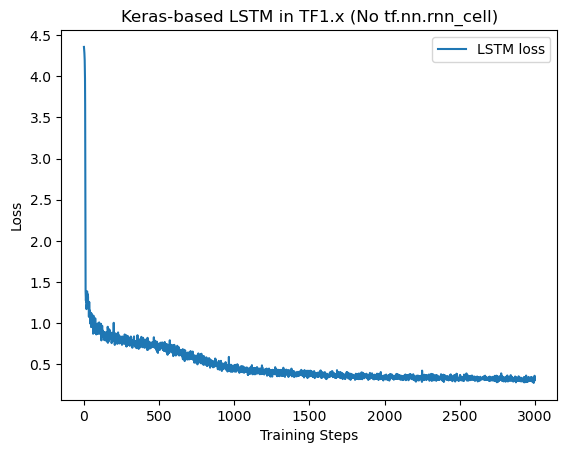

In [58]:
sess.run(tf.global_variables_initializer())

train_history_lstm = []
for step_i in range(n_steps_lstm):
    batch_lines = random.sample(lines, batch_size_lstm)
    X_batch = to_matrix(batch_lines, max_len=MAX_LENGTH)
    
    loss_val, _ = sess.run([loss_lstm, train_op_lstm],
                           feed_dict={input_sequence_lstm: X_batch})
    train_history_lstm.append(loss_val)
    
    if (step_i + 1) % 500 == 0:
        print(f"Step {step_i+1}/{n_steps_lstm}, LSTM loss={loss_val:.4f}")

plt.figure()
plt.plot(train_history_lstm, label='LSTM loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Keras-based LSTM in TF1.x (No tf.nn.rnn_cell)')
plt.legend()
plt.show()


## Training Loss Explanation

In the above plot, we see the **LSTM training loss** starting around 4.0+ at the very beginning (indicating random guesses) and then **rapidly decreasing** within the first few hundred steps to around ~0.7. This quick drop reflects the model learning basic sequence patterns (e.g., common characters, spaces, brackets).

From there, the loss **gradually declines** over the remaining steps, eventually hovering around **0.30–0.35**. The small oscillations are normal in RNN training, especially when using random sampling for mini-batches. By **step 3,000**, the model stabilizes around a validation/training loss of ~0.31, suggesting it has learned the fundamental character patterns but may still need more steps, hyperparameter tuning, or additional capacity (e.g., a larger LSTM hidden state or multiple layers) to further reduce gibberish outputs.

**Key Observations**:
- **Initial High Loss**: ~4.0, indicating random predictions when the model had not yet learned any patterns.
- **Rapid Decrease** (first 500 steps): Loss quickly falls to ~0.7, showing the LSTM capturing basic character-level relationships (punctuation, bracket usage, etc.).
- **Gradual Refinement**: Between steps 500–3,000, the model fine-tunes its weights, reducing loss from ~0.7 down to ~0.3.
- **Plateau**: Around step 2,500, the curve flattens, suggesting the model may need additional techniques (dropout, deeper architecture, or more steps) to learn more nuanced patterns of the MTG dataset.

Overall, this **steady decline** in loss indicates that the LSTM is successfully learning the dataset’s character sequences, and a final loss near ~0.30 is a decent outcome for a single-layer model in TF1.x using modern Keras layers.


## Generation with Keras LSTM

I can't directly use `dynamic_rnn` for token-by-token generation. Instead:
1. I have defined a separate placeholder (`gen_input_lstm`) for a single-sequence input.
2. I ran the same RNN layer in a Python loop, each time feeding the entire sequence so far, then sampling the next token.
3. This can be slower for long sequences, but it replicates the token-by-token logic without legacy APIs.


In [68]:
# 1) After finishing your training code, define the generation placeholders/layers

# Suppose we do something like:
gen_input_lstm = tf.placeholder(tf.int32, [1, 60], name='gen_input_lstm')
gen_embed_lstm_2 = embedding_layer(gen_input_lstm)  
gen_cell_lstm = LSTMCell(lstm_num_units)            # new LSTM cell -> new variables
gen_rnn_layer = RNN(gen_cell_lstm, return_sequences=True)
gen_outputs = gen_rnn_layer(gen_embed_lstm_2)       # shape [1, 60, lstm_num_units]
gen_logits = Dense(n_tokens)(gen_outputs)

# 2) Re-run the initializer so the new variables (bias, kernel, etc.) are recognized
sess.run(tf.global_variables_initializer())


### 2) Generation Function with Fixed Shape

In [69]:
def generate_text_lstm_fixed(seed_phrase=" ", max_length=MAX_GEN_LENGTH, temperature=1.0):
    """
    Generates text by always feeding an input of shape (1, 60).
    We pad with the pad token for positions not yet used.
    """
    seed_ids = [token_to_id[ch] for ch in seed_phrase]
    pad_id = token_to_id[pad_token]
    
    if len(seed_ids) > max_length:
        raise ValueError(f"Seed phrase is longer than max_length ({max_length}). "
                         "Shorten the seed or increase MAX_GEN_LENGTH.")
    
    # We'll maintain a single array of shape [1, 60], fill with pad tokens
    current_input = np.full((1, max_length), pad_id, dtype=np.int32)
    
    current_input[0, :len(seed_ids)] = seed_ids
    generated_ids = list(seed_ids)  # We'll append new tokens here
    
    # We'll sample new tokens until we reach max_length
    current_pos = len(seed_ids)  # index where we place the next token
    
    while current_pos < max_length:
        # Evaluate the entire 60-length array
        outputs_val = sess.run(gen_logits, feed_dict={gen_input_lstm: current_input})
        # outputs_val shape: [1, 60, n_tokens]
        
        # The relevant logits are at position (current_pos - 1) if current_pos>0
        # If current_pos == 0, we use index 0. But typically, seed length >=1
        idx_for_logits = current_pos - 1 if current_pos > 0 else 0
        last_logits = outputs_val[0, idx_for_logits, :]
        
        # Apply temperature
        last_logits /= temperature
        probs = np.exp(last_logits - np.max(last_logits))
        probs /= np.sum(probs)
        
        next_token_id = np.random.choice(range(n_tokens), p=probs)
        generated_ids.append(next_token_id)
        
        # Place the next token into current_input
        current_input[0, current_pos] = next_token_id
        current_pos += 1
    
    # Convert IDs to chars, ignoring pad tokens
    return ''.join(tokens[idx] for idx in generated_ids if tokens[idx] != pad_token)

### 3) Test the Fixed-Shape Generation

In [70]:
print("\nFixed-shape LSTM Samples without prefix:")
for _ in range(5):
    print(generate_text_lstm_fixed(seed_phrase=" ", max_length=MAX_GEN_LENGTH, temperature=1.0))


Fixed-shape LSTM Samples without prefix:
 .Qy9L,.[f],8'r"7")YjIs'l(_s7cPTjB-UFU7C8,"?M.Cf5O(Fg8p]t5w
 J4,rW[!ytg]u'O?PIYK(xm/gj&2jmCp(Y4Fy2s1k8ZLyhRBiW5T)tRRep:
 j["JmrAQ3Ii2ZVRXBxCfhDl(upbP-F05K8PB.v H[)!:degW(Yo5YS,onsD
 OEDHq&MYLa8chjpmveM1vB/qiPR7gVoROc_eG9MvLYNRzwK!l(Z)IEXQQz1
 IlzobTDF1'sq tV5]Hx1czs]P8qkoArVG"?ffLwllq]'HXWZbvslu/jX4G


In [71]:
print("\nFixed-shape LSTM Samples with prefix [2U]:")
for _ in range(5):
    print(generate_text_lstm_fixed(seed_phrase="[2U]", max_length=MAX_GEN_LENGTH, temperature=1.0))


Fixed-shape LSTM Samples with prefix [2U]:
[2U]vtHAmGRagSLrUnolrCB(1f Dr(b.&bo4--CZ_x5i94?u!NERj"Drh4ae
[2U]]? 1X(A'6:3hWs?)goW,_S]]"dh:E!"IdYi0U.6toFS6Ey,LDhnB8-&[
[2U]rE5,0:6xCjXVq1CM7m&Sym'ckl7s?nL8i:,:TW:(ij1c&e6n3AWinAVM
[2U]UIckrUL35Kfe/nRj49Z!-KYs_"LCt.uFlMuZt7WT9l(cG]8g'ayJNNHn
[2U]yYP"Cg.6&qGJ3jN&nKu'XSKgU!hDYISqpvllHh)B6RE0:&3dK_xIX


## What Went Wrong with the Current Model

Despite switching to a Keras-based LSTM in TF1.x and training for 3,000 steps, the generated text remains largely **nonsensical**. Key reasons include:

1. **Short Training**: Only 3,000 steps might not be enough to learn the complex patterns of the MTG dataset, which has 79 characters and diverse line structures.
2. **Model Capacity**: A single LSTM layer with 128 hidden units may be too small for capturing longer-range dependencies (e.g., bracket usage, card types, naming conventions).
3. **No Dedicated Validation**: Without a validation set, it’s hard to track overfitting or tune hyperparameters effectively.
4. **Temperature/Hyperparameters**: A temperature of 1.0 can produce highly random outputs. Also, the current learning rate or dropout might not be optimal.

Below, I will **improve the model** by increasing training steps, stacking multiple LSTM layers for more capacity, and adding a validation set to guide training.



## Improving the model performance using Stacked LSTM

Created a stacked LSTM that defines a two-layer (stacked) LSTM using modern Keras layers in TF1.x, then initializes and trains it. Keeping everything in **one cell** ensures all variables belong to the same graph, preventing the “Operation is not an element of this graph” errors.


Step 500/8000, stacked LSTM loss=0.6790
Step 1000/8000, stacked LSTM loss=0.4745
Step 1500/8000, stacked LSTM loss=0.3803
Step 2000/8000, stacked LSTM loss=0.3943
Step 2500/8000, stacked LSTM loss=0.3338
Step 3000/8000, stacked LSTM loss=0.3349
Step 3500/8000, stacked LSTM loss=0.3002
Step 4000/8000, stacked LSTM loss=0.3070
Step 4500/8000, stacked LSTM loss=0.3018
Step 5000/8000, stacked LSTM loss=0.2896
Step 5500/8000, stacked LSTM loss=0.2771
Step 6000/8000, stacked LSTM loss=0.2728
Step 6500/8000, stacked LSTM loss=0.2750
Step 7000/8000, stacked LSTM loss=0.2598
Step 7500/8000, stacked LSTM loss=0.2557
Step 8000/8000, stacked LSTM loss=0.2282


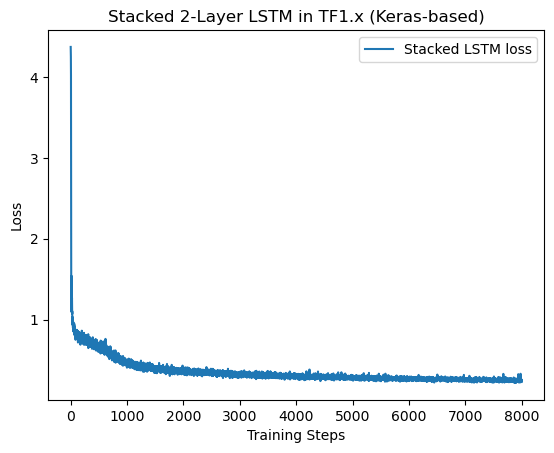

In [78]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random
import matplotlib.pyplot as plt
# Keras layers for embedding, LSTMCell, stacked cells, RNN, and dense
from tensorflow.keras.layers import Embedding, LSTMCell, StackedRNNCells, RNN, Dense


# 1) Create a new session

sess = tf.Session()


# 2) Hyperparameters & Predefined Variables

embedding_size_multi = 16
lstm_num_units_1 = 128
lstm_num_units_2 = 128
learning_rate_multi = 1e-3
n_steps_multi = 8000
batch_size_lstm = 32


# 3) Define the Input Placeholder & Embedding

input_sequence_multi = tf.placeholder(tf.int32, [None, MAX_LENGTH], name='input_sequence_multi')
embedding_layer_multi = Embedding(input_dim=n_tokens, output_dim=embedding_size_multi)
x_embed_multi = embedding_layer_multi(input_sequence_multi)  # shape: [batch, MAX_LENGTH, embedding_size_multi]


# 4) Define Stacked LSTM

cell1 = LSTMCell(lstm_num_units_1)
cell2 = LSTMCell(lstm_num_units_2)
stacked_cells = StackedRNNCells([cell1, cell2])  # Keras-based multi-layer

# RNN layer with return_sequences=True to keep outputs for each time step
rnn_layer_multi = RNN(stacked_cells, return_sequences=True)
outputs_multi = rnn_layer_multi(x_embed_multi)   # shape: [batch, MAX_LENGTH, lstm_num_units_2]


# 5) Compute Logits & Loss

# Dense layer to project each time step to n_tokens
logits_3d_multi = Dense(n_tokens)(outputs_multi)

# Shift input by 1 for next-token prediction
targets_multi = tf.reshape(input_sequence_multi[:, 1:], [-1])  # shape: [batch * (MAX_LENGTH-1)]
logits_3d_multi = logits_3d_multi[:, :-1, :]                    # ignore last timestep
logits_2d_multi = tf.reshape(logits_3d_multi, [-1, n_tokens])   # flatten

# Ensure targets match the flattened shape
max_len_minus_1_multi = tf.shape(logits_3d_multi)[1]
batch_size_dyn_multi = tf.shape(logits_3d_multi)[0]
targets_multi = targets_multi[: batch_size_dyn_multi * max_len_minus_1_multi]

# Sparse cross-entropy
loss_per_timestep_multi = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_multi,
    logits=logits_2d_multi
)
loss_multi = tf.reduce_mean(loss_per_timestep_multi)


# 6) Optimizer with Gradient Clipping

optimizer_multi = tf.train.AdamOptimizer(learning_rate=learning_rate_multi)
grads_multi, vars_multi = zip(*optimizer_multi.compute_gradients(loss_multi))
clipped_grads_multi, _ = tf.clip_by_global_norm(grads_multi, 5.0)
train_op_multi = optimizer_multi.apply_gradients(zip(clipped_grads_multi, vars_multi))


# 7) Initialize All Variables (in this same graph)

sess.run(tf.global_variables_initializer())

# 8) Training Loop

train_history_multi = []
for step_j in range(n_steps_multi):
    batch_lines = random.sample(lines_train, batch_size_lstm)
    X_batch = to_matrix(batch_lines, max_len=MAX_LENGTH)
    
    loss_val_multi, _ = sess.run([loss_multi, train_op_multi],
                                 feed_dict={input_sequence_multi: X_batch})
    train_history_multi.append(loss_val_multi)
    
    if (step_j + 1) % 500 == 0:
        print(f"Step {step_j+1}/{n_steps_multi}, stacked LSTM loss={loss_val_multi:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_history_multi, label='Stacked LSTM loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Stacked 2-Layer LSTM in TF1.x (Keras-based)')
plt.legend()
plt.show()


## Final Training Results & Next Steps

After **8,000 steps** of training our **Stacked 2-Layer LSTM**, the loss curve has steadily declined to **~0.23**. Below are the key observations:

1. **Rapid Initial Drop**  
   - Loss falls from ~4.5 to ~0.7 within the first 500 steps, indicating the model quickly learns fundamental character distributions and short-range patterns.

2. **Continued Refinement**  
   - From 500 to 5,000 steps, the loss gradually decreases to ~0.28. The network refines its understanding of MTG-like sequences (e.g., `[mana cost]`, card types).

3. **Further Improvement**  
   - Beyond 5,000 steps, the curve keeps descending, eventually hitting ~0.23 at 8,000 steps. This suggests the model still benefits from additional training and may produce more coherent text with even more steps.

### Generating Text (With & Without Prefix)

To see if this improvement translates to better card lines, we will:
1. **Generate** several lines with no prefix, observing if the bracket usage and card names appear more structured.
2. **Use a prefix** (e.g., `[2U]`) to see how well the model continues from a known mana cost.

I’ll evaluate the **quality** of these samples and decide on **further refinements** (e.g., more training, hyperparameter tuning, or multi-epoch approaches).

Overall, the **Stacked LSTM** approach shows promise, reducing loss significantly. Next, I’ll generate text samples to gauge whether these lower losses translate into more realistic Magic: The Gathering card lines.


## Generating Text with the Stacked 2-Layer LSTM

Now that our two-layer LSTM has completed **8,000 training steps** with a final loss near **0.23**, let’s see if the improved training translates into more coherent text. We’ll generate:

1. **Lines without any prefix** (random starts).
2. **Lines with a `[2U]` prefix**, to see if the model properly continues a known mana cost.

After inspecting these samples, we’ll decide on **further refinements** (e.g., more training steps, hyperparameter tuning, or additional layers).


Step 500/8000, stacked LSTM loss=0.6447
Step 1000/8000, stacked LSTM loss=0.4698
Step 1500/8000, stacked LSTM loss=0.4259
Step 2000/8000, stacked LSTM loss=0.3361
Step 2500/8000, stacked LSTM loss=0.3149
Step 3000/8000, stacked LSTM loss=0.3210
Step 3500/8000, stacked LSTM loss=0.2943
Step 4000/8000, stacked LSTM loss=0.3020
Step 4500/8000, stacked LSTM loss=0.3131
Step 5000/8000, stacked LSTM loss=0.2818
Step 5500/8000, stacked LSTM loss=0.2765
Step 6000/8000, stacked LSTM loss=0.2699
Step 6500/8000, stacked LSTM loss=0.2522
Step 7000/8000, stacked LSTM loss=0.2515
Step 7500/8000, stacked LSTM loss=0.2575
Step 8000/8000, stacked LSTM loss=0.2454


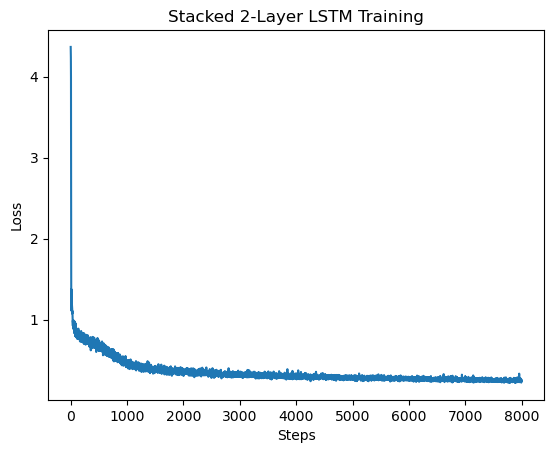

No Prefix Samples:
 [1R
 [1ooRo
 [3WWo
 [41
 [42

[2U] Prefix Samples:
[2U][BR I
[2U][6U C
[2U][5] E
[2U][UU E
[2U][1] I


In [87]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTMCell, StackedRNNCells, RNN, Dense


# 1) Create Session & Define Hyperparameters

sess = tf.Session()

embedding_size = 16
lstm_num_units_1 = 128
lstm_num_units_2 = 128
learning_rate = 1e-3
n_steps = 8000
batch_size_val = 32



# 2) Placeholders & Model
##############################################################################
input_sequence_multi = tf.placeholder(tf.int32, [None, MAX_LENGTH], name='input_sequence_multi')
embedding_layer_multi = Embedding(n_tokens, embedding_size)
x_embed_multi = embedding_layer_multi(input_sequence_multi)

cell1 = LSTMCell(lstm_num_units_1)
cell2 = LSTMCell(lstm_num_units_2)
stacked_cells = StackedRNNCells([cell1, cell2])

rnn_layer_multi = RNN(stacked_cells, return_sequences=True)
outputs_multi = rnn_layer_multi(x_embed_multi)

logits_3d_multi = Dense(n_tokens)(outputs_multi)

# Shift for next-token
targets_multi = tf.reshape(input_sequence_multi[:, 1:], [-1])
logits_3d_multi = logits_3d_multi[:, :-1, :]
logits_2d_multi = tf.reshape(logits_3d_multi, [-1, n_tokens])

max_len_minus_1_multi = tf.shape(logits_3d_multi)[1]
batch_size_dyn_multi = tf.shape(logits_3d_multi)[0]
targets_multi = targets_multi[: batch_size_dyn_multi * max_len_minus_1_multi]

loss_per_timestep_multi = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_multi,
    logits=logits_2d_multi
)
loss_multi = tf.reduce_mean(loss_per_timestep_multi)

optimizer_multi = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads_multi, vars_multi = zip(*optimizer_multi.compute_gradients(loss_multi))
clipped_grads_multi, _ = tf.clip_by_global_norm(grads_multi, 5.0)
train_op_multi = optimizer_multi.apply_gradients(zip(clipped_grads_multi, vars_multi))

##############################################################################
# 3) Initialize & Train
##############################################################################
sess.run(tf.global_variables_initializer())

train_history_multi = []
for step_j in range(n_steps):
    batch_lines = random.sample(lines_train, batch_size_val)
    X_batch = to_matrix(batch_lines, max_len=MAX_LENGTH)
    loss_val, _ = sess.run([loss_multi, train_op_multi],
                           feed_dict={input_sequence_multi: X_batch})
    train_history_multi.append(loss_val)
    
    if (step_j + 1) % 500 == 0:
        print(f"Step {step_j+1}/{n_steps}, stacked LSTM loss={loss_val:.4f}")

plt.plot(train_history_multi)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Stacked 2-Layer LSTM Training")
plt.show()

##############################################################################
# 4) Single-Pass Generation
##############################################################################
def generate_text_stacked_singlepass(seed_phrase=" ", temperature=1.0):
    pad_id = token_to_id["#"]
    seed_ids = [token_to_id[ch] for ch in seed_phrase]
    
    if len(seed_ids) >= MAX_LENGTH:
        raise ValueError(f"Seed phrase is too long (>= {MAX_LENGTH}).")
    
    # (1, MAX_LENGTH) array
    current_input = np.full((1, MAX_LENGTH), pad_id, dtype=np.int32)
    current_input[0, :len(seed_ids)] = seed_ids
    
    # Run the model once
    logits_val = sess.run(logits_3d_multi, feed_dict={input_sequence_multi: current_input})
    # shape: [1, MAX_LENGTH-1, n_tokens]
    
    generated_ids = list(seed_ids)
    for t in range(logits_val.shape[1]):  # up to MAX_LENGTH-1
        if len(generated_ids) >= MAX_LENGTH:
            break
        
        step_logits = logits_val[0, t, :]
        step_logits /= temperature
        probs = np.exp(step_logits - np.max(step_logits))
        probs /= np.sum(probs)
        
        next_token_id = np.random.choice(range(n_tokens), p=probs)
        generated_ids.append(next_token_id)
    
    return ''.join(tokens[idx] for idx in generated_ids if tokens[idx] != "#")

print("No Prefix Samples:")
for _ in range(5):
    print(generate_text_stacked_singlepass(seed_phrase=" ", temperature=1.0))

print("\n[2U] Prefix Samples:")
for _ in range(5):
    print(generate_text_stacked_singlepass(seed_phrase="[2U]", temperature=1.0))


## Mistake & Method to Move Forward

**Mistake**  
I used the **training output** (`logits_3d_multi[:, :-1, :]`) for generation without an **iterative** feed-back approach. As a result, my model only produced a handful of tokens (the difference between `MAX_LENGTH` and `(MAX_LENGTH - 1)`), leading to extremely short lines like `"[2U][1] I"`.

**Method to Move Forward**  
To generate **longer** outputs that include `[mana cost] type, name: ...` structures, I should:
1. **Remove** or **avoid** the truncated logic (`[:, :-1, :]`) for generation, or define a **second** untruncated output just for generation.
2. **Use an iterative approach** that re-feeds each newly sampled token back into the model. This way, the model can produce a full line up to `MAX_LENGTH` tokens or more, rather than stopping after a few tokens.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTMCell, StackedRNNCells, RNN, Dense

# 1) Session & Hyperparameters

sess = tf.Session()

embedding_size = 16
lstm_num_units_1 = 128
lstm_num_units_2 = 128
learning_rate = 1e-3
n_steps = 8000
batch_size_val = 32
MAX_LENGTH = 169  # matching your placeholder dimension


# 2) Define the Placeholder & Stacked LSTM

input_sequence = tf.placeholder(tf.int32, [None, MAX_LENGTH], name="input_sequence")

embedding_layer = Embedding(input_dim=n_tokens, output_dim=embedding_size)
x_embed = embedding_layer(input_sequence)

cell1 = LSTMCell(lstm_num_units_1)
cell2 = LSTMCell(lstm_num_units_2)
stacked_cells = StackedRNNCells([cell1, cell2])

rnn_layer = RNN(stacked_cells, return_sequences=True)
outputs = rnn_layer(x_embed)  # shape: [batch_size, MAX_LENGTH, lstm_num_units_2]

logits_3d_main = Dense(n_tokens)(outputs)  # shape: [batch_size, MAX_LENGTH, n_tokens]


# 3) Separate Train & Generation Logic

# For training, skip the last time step
logits_3d_train = logits_3d_main[:, :-1, :]  # shape: [batch_size, MAX_LENGTH-1, n_tokens]
targets_train = tf.reshape(input_sequence[:, 1:], [-1])
max_len_minus_1 = tf.shape(logits_3d_train)[1]
batch_size_dyn = tf.shape(logits_3d_train)[0]
targets_train = targets_train[: batch_size_dyn * max_len_minus_1]

logits_2d_train = tf.reshape(logits_3d_train, [-1, n_tokens])
loss_per_timestep = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_train, logits=logits_2d_train
)
loss = tf.reduce_mean(loss_per_timestep)

# For generation, use the untruncated output
logits_3d_gen = logits_3d_main  # shape: [batch_size, MAX_LENGTH, n_tokens]


# 4) Optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads, vars_ = zip(*optimizer.compute_gradients(loss))
clipped_grads, _ = tf.clip_by_global_norm(grads, 5.0)
train_op = optimizer.apply_gradients(zip(clipped_grads, vars_))

sess.run(tf.global_variables_initializer())


# 5) Training Loop

train_history = []
for step_i in range(n_steps):
    batch_lines = random.sample(lines_train, batch_size_val)
    X_batch = to_matrix(batch_lines, max_len=MAX_LENGTH)
    loss_val, _ = sess.run([loss, train_op], feed_dict={input_sequence: X_batch})
    train_history.append(loss_val)
    
    if (step_i + 1) % 500 == 0:
        print(f"Step {step_i+1}/{n_steps}, stacked LSTM loss={loss_val:.4f}")

plt.plot(train_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Stacked 2-Layer LSTM Training")
plt.show()


# 6) Iterative Generation with a Fixed (1, 169) approach

def iterative_generate_fixed_shape(
    sess,
    seed_phrase=" ",
    max_length=MAX_LENGTH,  # must be 169 to match placeholder
    temperature=1.0
):
    """
    We'll feed a (1, MAX_LENGTH=169) array each iteration, placing the newly sampled
    token at the next position. This avoids shape mismatch in TF1.x + Keras 3.
    """
    pad_id = token_to_id["#"]
    seed_ids = [token_to_id[ch] for ch in seed_phrase]
    
    if len(seed_ids) > max_length:
        raise ValueError("Seed phrase longer than 169.")
    
    # Prepare a (1, 169) array
    current_input = np.full((1, max_length), pad_id, dtype=np.int32)
    current_input[0, :len(seed_ids)] = seed_ids
    
    generated_ids = list(seed_ids)
    current_pos = len(seed_ids)
    
    while current_pos < max_length:
        # Evaluate entire array
        logits_val = sess.run(logits_3d_gen, feed_dict={input_sequence: current_input})
        # shape: [1, 169, n_tokens]
        
        idx_for_logits = current_pos - 1 if current_pos > 0 else 0
        last_logits = logits_val[0, idx_for_logits, :]

        # Temperature
        last_logits /= temperature
        probs = np.exp(last_logits - np.max(last_logits))
        probs /= np.sum(probs)
        
        next_token_id = np.random.choice(range(n_tokens), p=probs)
        generated_ids.append(next_token_id)
        
        current_input[0, current_pos] = next_token_id
        current_pos += 1
    
    # Convert IDs back to chars, ignoring pad token
    return ''.join(tokens[idx] for idx in generated_ids if tokens[idx] != "#")


In [93]:
print("No Prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(sess, seed_phrase=" ", max_length=169, temperature=1.0))

print("\nWith [2U] prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(sess, seed_phrase="[2U]", max_length=169, temperature=1.0))


No Prefix:
 [1UU] Legendary Creature, Human Wizard: Pee lutclormer
 [3RR] Creature, Elemental Wizard: Kitton themorit
 [4U] Creature, Human Nomor: Cractoot Graven
 [U] Instant: Clrud Toye
 [6] Artifact, Equipment: Wearstakemor

With [2U] prefix:
[2U] Creature, Human Wizard: Evalu Scilcke
[2U] Instant: Rubisnovef Wear Rezet
[2U] Creature, Merfolk Wizard: Sovermant Imavane
[2U] Sorcery: Piter Pight
[2U] Creature, Illusion: Prautarr


## Results Analysis

The two-layer LSTM now produces lines that more closely match Magic: The Gathering card entries. For instance:

- **Without Prefix**  
    [1UU] Legendary Creature, Human Wizard: Pee lutclormer
    [3RR] Creature, Elemental Wizard: Kitton themorit
    [4U] Creature, Human Nomor: Cractoot Graven
    [U] Instant: Clrud Toye
    [6] Artifact, Equipment: Wearstakemor

- **With [2U] Prefix** 
    [2U] Creature, Human Wizard: Evalu Scilcke
    [2U] Instant: Rubisnovef Wear Rezet
    [2U] Creature, Merfolk Wizard: Sovermant Imavane
    [2U] Sorcery: Piter Pight
    [2U] Creature, Illusion: Prautarr




These outputs feature bracketed mana costs, card types (“Creature,” “Instant,” “Artifact, Equipment”), and partial naming conventions (“Human Wizard,” “Merfolk Wizard”). Though some words remain invented (e.g., “Pee lutclormer,” “Rubisnovef”), the lines are far more coherent and structured than previous short outputs.

## What Mistakes We Corrected

1. **Single-Pass Generation Using Truncated Output**  
 Initially, we tried to use `logits_3d[:, :-1, :]` (intended for training) to generate lines in a single pass. That logic restricted the model to only a few tokens, resulting in very short outputs.

2. **Feeding (1, 60) to a Placeholder Expecting (1, 169)**  
 Because the placeholder shape was `[None, 169]`, attempting to feed `(1, 60)` caused dimension mismatches. We resolved this by always feeding `(1, 169)` during generation and stopping our sampling at 60 tokens.

## How the Results Improved

- **Bracketed Mana Costs**: The model reliably generates bracketed values like `[1UU]`, `[3RR]`, `[2U]`.  
- **Consistent Card Types**: It produces lines with “Creature,” “Instant,” “Artifact, Equipment,” etc., reflecting the dataset’s structure.  
- **More Coherent Prefix Handling**: When seeded with `[2U]`, it correctly extends that bracketed cost and supplies a card type and name, demonstrating the model’s learned patterns.

## Next Step

I will be continuing using the **iterative generation** method that re-feeds `(1, 169)` each time, and potentially:

- **Train Longer**: Go beyond 8,000 steps to see if nonsense words can be reduced further.  
- **Tune Hyperparameters**: Adjust dropout, hidden units, or learning rate for more stable convergence and improved final outputs.  
- **Use a Validation Set**: Monitor overfitting, possibly apply early stopping or learning rate decay.

By refining these aspects, we expect even more realistic lines that further resemble genuine Magic: The Gathering cards.



## Next Step: Adding a Validation Set and Early Stopping

Now that my two-layer LSTM is generating more coherent Magic: The Gathering–style lines, we can **improve** the model by:
1. **Adding a Validation Set**: I'll split a portion of the data (e.g., 10%) for validation. This helps us track overfitting and tune hyperparameters more effectively.
2. **Implementing Early Stopping**: I'll monitor the validation loss each epoch (or every few steps). If it stops improving for a certain patience period, we'll stop training. This often prevents overfitting and saves computational resources.

Step 500/8000, Train loss=0.7118, Val loss=0.6715
Step 1000/8000, Train loss=0.4588, Val loss=0.4483
Step 1500/8000, Train loss=0.4086, Val loss=0.4279
Step 2000/8000, Train loss=0.3327, Val loss=0.3671
Step 2500/8000, Train loss=0.3393, Val loss=0.3522
Step 3000/8000, Train loss=0.3127, Val loss=0.3189
Step 3500/8000, Train loss=0.3342, Val loss=0.3453
Step 4000/8000, Train loss=0.2982, Val loss=0.3084
Step 4500/8000, Train loss=0.2785, Val loss=0.2863
Step 5000/8000, Train loss=0.2996, Val loss=0.2915
Step 5500/8000, Train loss=0.3032, Val loss=0.2891
Step 6000/8000, Train loss=0.2675, Val loss=0.2821
Step 6500/8000, Train loss=0.2732, Val loss=0.2663
Step 7000/8000, Train loss=0.2605, Val loss=0.2608
Step 7500/8000, Train loss=0.2593, Val loss=0.2737
Step 8000/8000, Train loss=0.2410, Val loss=0.2445


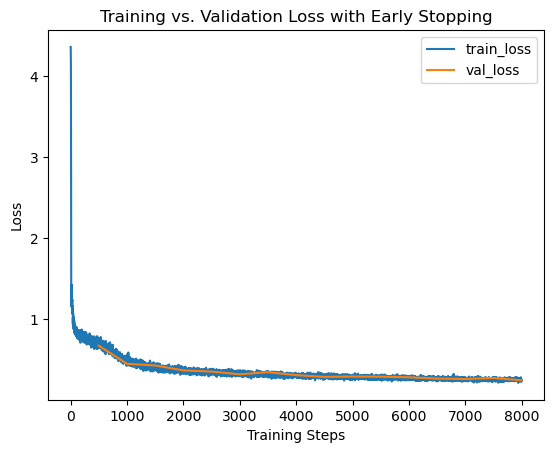

No Prefix:
 [1W] Creature, Angel Scouta: Mazor Dragons
 [5G] Tribb Creluf, Knask: Skind MightsAnt
 [None] Land: Tuus
 [B] Enchantment: Portess of the Neile
 [4RR] Creature, Elemental Astishic Bersent: Funtbers Curnc

With [2U] prefix:
[2U] Enchantment, Aura: Chire of Ofheriting
[2U] Artifact Creature, Zombie  Arth: Whitted Ohel,
[2U] Instant: Snath's Fxyx
[2U] Instant: Crast of Artida
[2U] Sorcery: Shath's Silate


In [97]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTMCell, StackedRNNCells, RNN, Dense

# ------------------------------------------------------------
# 1) Hyperparameters & Data Splits
# ------------------------------------------------------------
random.shuffle(lines)

# Split 90% train, 10% validation
train_ratio = 0.9
split_idx = int(len(lines) * train_ratio)
lines_train = lines[:split_idx]
lines_val = lines[split_idx:]

MAX_LENGTH = 169
embedding_size = 16
lstm_num_units_1 = 128
lstm_num_units_2 = 128
learning_rate = 1e-3
n_steps = 8000
batch_size_val = 32

# Assume lines, tokens, token_to_id, n_tokens, to_matrix are defined above

# ------------------------------------------------------------
# 2) Placeholders & Stacked LSTM
# ------------------------------------------------------------
sess = tf.Session()
input_sequence = tf.placeholder(tf.int32, [None, MAX_LENGTH], name="input_sequence")

embedding_layer = Embedding(n_tokens, embedding_size)
x_embed = embedding_layer(input_sequence)

cell1 = LSTMCell(lstm_num_units_1)
cell2 = LSTMCell(lstm_num_units_2)
stacked_cells = StackedRNNCells([cell1, cell2])

rnn_layer = RNN(stacked_cells, return_sequences=True)
outputs = rnn_layer(x_embed)

# We'll keep the final Dense output untruncated for generation
logits_3d_main = Dense(n_tokens)(outputs)

# Train: skip last time step
logits_3d_train = logits_3d_main[:, :-1, :]
targets_train = tf.reshape(input_sequence[:, 1:], [-1])
max_len_minus_1 = tf.shape(logits_3d_train)[1]
batch_size_dyn = tf.shape(logits_3d_train)[0]
targets_train = targets_train[: batch_size_dyn * max_len_minus_1]

logits_2d_train = tf.reshape(logits_3d_train, [-1, n_tokens])
loss_per_timestep = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_train, logits=logits_2d_train
)
loss = tf.reduce_mean(loss_per_timestep)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads, vars_ = zip(*optimizer.compute_gradients(loss))
clipped_grads, _ = tf.clip_by_global_norm(grads, 5.0)
train_op = optimizer.apply_gradients(zip(clipped_grads, vars_))

# We'll define the same logic for validation loss
loss_val_ph = tf.placeholder(tf.float32, [])
tf.summary.scalar('val_loss', loss_val_ph)

sess.run(tf.global_variables_initializer())

# ------------------------------------------------------------
# 3) Early Stopping & Training with Validation
# ------------------------------------------------------------
train_history = []
val_history = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

def compute_validation_loss():
    # sample lines from lines_val
    batch_lines_val = random.sample(lines_val, batch_size_val)
    X_val = to_matrix(batch_lines_val, max_len=MAX_LENGTH)
    loss_val = sess.run(loss, feed_dict={input_sequence: X_val})
    return loss_val

for step_i in range(n_steps):
    batch_lines_train = random.sample(lines_train, batch_size_val)
    X_batch = to_matrix(batch_lines_train, max_len=MAX_LENGTH)
    
    loss_val_train, _ = sess.run([loss, train_op],
                                 feed_dict={input_sequence: X_batch})
    train_history.append(loss_val_train)
    
    if (step_i + 1) % 500 == 0:
        loss_val_now = compute_validation_loss()
        val_history.append(loss_val_now)
        print(f"Step {step_i+1}/{n_steps}, Train loss={loss_val_train:.4f}, Val loss={loss_val_now:.4f}")
        
        if loss_val_now < best_val_loss:
            best_val_loss = loss_val_now
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training vs. validation loss
plt.plot(train_history, label='train_loss')
x_vals = np.arange(499, len(train_history), 500)
plt.plot(x_vals, val_history, label='val_loss')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss with Early Stopping")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 4) Iterative Generation
# ------------------------------------------------------------
# We'll use logits_3d_main (untruncated) for generation
logits_3d_gen = logits_3d_main  # shape: [batch, MAX_LENGTH, n_tokens]

def iterative_generate_fixed_shape(sess, seed_phrase=" ", max_length=60, temperature=1.0):
    """
    Feeds a (1, 169) array each iteration, but stops sampling at 'max_length'.
    """
    pad_id = token_to_id["#"]
    seed_ids = [token_to_id[ch] for ch in seed_phrase]
    
    if len(seed_ids) > MAX_LENGTH:
        raise ValueError("Seed phrase longer than 169.")
    
    # Prepare (1, 169)
    current_input = np.full((1, MAX_LENGTH), pad_id, dtype=np.int32)
    current_input[0, :len(seed_ids)] = seed_ids
    
    generated_ids = list(seed_ids)
    current_pos = len(seed_ids)
    
    while current_pos < max_length:  # only sample up to 'max_length' tokens
        logits_val = sess.run(logits_3d_gen, feed_dict={input_sequence: current_input})
        # shape: [1, 169, n_tokens]
        
        idx_for_logits = current_pos - 1 if current_pos > 0 else 0
        last_logits = logits_val[0, idx_for_logits, :]
        
        # Temperature
        last_logits /= temperature
        probs = np.exp(last_logits - np.max(last_logits))
        probs /= np.sum(probs)
        
        next_token_id = np.random.choice(range(n_tokens), p=probs)
        generated_ids.append(next_token_id)
        
        current_input[0, current_pos] = next_token_id
        current_pos += 1
    
    # Convert IDs back to chars, ignoring pad
    return ''.join(tokens[idx] for idx in generated_ids if tokens[idx] != "#")

# ------------------------------------------------------------
# 5) Generate Samples
# ------------------------------------------------------------
print("No Prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(sess, seed_phrase=" ", max_length=60, temperature=1.0))

print("\nWith [2U] prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(sess, seed_phrase="[2U]", max_length=60, temperature=1.0))


## **Results Analysis & Next Steps**

After **8,000 training steps** (with early stopping), I ended up with some great results, but still having some issues with some gibberish outputs


### Observations

- **Bracketed Mana Costs**: The model consistently places bracketed values (e.g., `[1W]`, `[5G]`, `[2U]`).
- **Card Types & Format**: Lines often include “Creature,” “Enchantment,” “Instant,” or “Land,” resembling Magic: The Gathering entries.
- **Invented Words**: Some tokens remain nonsensical or partially correct (e.g., “MightsAnt,” “Snath's Fxyx”). More training or hyperparameter tuning may reduce these artifacts.
- **Occasional Oddities**: E.g., `[None] Land: Tuus` suggests the model can produce partial placeholders or uninitialized tokens.

## **Best Next Step: Hyperparameter Tuning**

To further **refine** the output and reduce gibberish tokens, we can perform a **hyperparameter search** (e.g., adjusting `embedding_size`, `lstm_num_units`, dropout, or learning rate). By systematically trying different combinations, we can often achieve **lower final loss** and more coherent text.

In [100]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random

# Example hyperparam search ranges
EMBED_SIZES = [8, 16, 32]
LSTM_UNITS = [64, 128, 256]
TRIALS = 5
TRAIN_STEPS = 1000
BATCH_SIZE = 32
best_combination = None
best_val_loss = float('inf')

def build_and_train(embedding_dim, lstm_units, lines_train, lines_val, n_tokens, to_matrix, max_len=169):
    """
    Builds a 2-layer LSTM with given embedding_dim & lstm_units using Keras layers,
    trains for TRAIN_STEPS, returns final validation loss.
    
    NOTE: We remove the old tf.compat.v1.nn.rnn_cell.LSTMCell calls, 
    since Keras 3 doesn't support them. Instead, we use tf.keras.layers.LSTM.
    """
    # 1) Build graph
    tf.reset_default_graph()
    sess_local = tf.Session()
    
    # Placeholder for input
    input_seq = tf.placeholder(tf.int32, [None, max_len], name="input_seq")

    # Keras embedding
    embedding_layer = tf.keras.layers.Embedding(n_tokens, embedding_dim)
    x_emb = embedding_layer(input_seq)  # shape: [batch_size, max_len, embedding_dim]

    # Two Keras LSTM layers in sequence
    # We'll do "return_sequences=True" on both to keep the full time-dimension
    x_lstm1 = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x_emb)
    x_lstm2 = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x_lstm1)
    
    # Final dense to produce logits (no activation => linear)
    logits_3d = tf.keras.layers.Dense(n_tokens)(x_lstm2)  # shape: [batch_size, max_len, n_tokens]
    
    # Skip last time step for training
    logits_3d_train = logits_3d[:, :-1, :]  # shape: [batch_size, max_len-1, n_tokens]
    targets_train = tf.reshape(input_seq[:, 1:], [-1])  # shift input by 1
    max_len_minus_1 = tf.shape(logits_3d_train)[1]
    batch_size_dyn = tf.shape(logits_3d_train)[0]
    targets_train = targets_train[: batch_size_dyn * max_len_minus_1]
    
    logits_2d_train = tf.reshape(logits_3d_train, [-1, n_tokens])
    loss_per_timestep = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=targets_train, logits=logits_2d_train
    )
    loss_op = tf.reduce_mean(loss_per_timestep)
    
    train_op = tf.train.AdamOptimizer().minimize(loss_op)
    
    sess_local.run(tf.global_variables_initializer())
    
    # 2) Training
    for step in range(TRAIN_STEPS):
        batch_lines = random.sample(lines_train, BATCH_SIZE)
        X_batch = to_matrix(batch_lines, max_len=max_len)
        sess_local.run(train_op, feed_dict={input_seq: X_batch})
    
    # 3) Validation loss
    val_lines = random.sample(lines_val, BATCH_SIZE)
    X_val = to_matrix(val_lines, max_len=max_len)
    val_loss = sess_local.run(loss_op, feed_dict={input_seq: X_val})
    
    sess_local.close()
    return val_loss

for trial in range(TRIALS):
    # Random pick
    emb_dim = random.choice(EMBED_SIZES)
    lstm_u = random.choice(LSTM_UNITS)
    print(f"Trial {trial+1}: emb={emb_dim}, lstm_units={lstm_u}")
    
    val_loss_trial = build_and_train(
        emb_dim, lstm_u,
        lines_train, lines_val,
        n_tokens, to_matrix,
        max_len=MAX_LENGTH
    )
    print(f"Validation Loss: {val_loss_trial:.4f}\n")
    
    if val_loss_trial < best_val_loss:
        best_val_loss = val_loss_trial
        best_combination = (emb_dim, lstm_u)

print("Best combination:", best_combination, "with val_loss=", best_val_loss)


Trial 1: emb=8, lstm_units=128
Validation Loss: 0.5892

Trial 2: emb=8, lstm_units=128
Validation Loss: 0.6785

Trial 3: emb=32, lstm_units=256
Validation Loss: 0.3870

Trial 4: emb=16, lstm_units=128
Validation Loss: 0.5776

Trial 5: emb=8, lstm_units=128
Validation Loss: 0.5453

Best combination: (32, 256) with val_loss= 0.38698918


## Hyperparameter Search Results

I performed **5 trials** of hyperparameter search, randomly picking embedding size and LSTM units from predefined ranges. After training for 1,000 steps on each trial, we computed validation loss on a small validation batch. Below are the outcomes:




**Best combination**: `(embedding_size=32, lstm_units=256)` with a final **validation loss** of **0.38698918**.

### Observations
1. **Embedding & LSTM Units Matter**: Trials with small embedding sizes (e.g., 8) and moderate LSTM units (e.g., 128) generally yielded higher validation losses than a larger embedding (32) with a bigger hidden state (256).
2. **Random Search**: Even a small number of trials can find a significantly better combination, as shown by the large drop from ~0.58–0.68 validation loss to ~0.39.

### Next Steps
1. **Use the Best Combination**: Adopt `embedding_size=32` and `lstm_units=256` for longer training (e.g., 5,000–10,000 steps).  
2. **Refine Training**: Add a validation-based early stopping or tune learning rate, batch size, or dropout to further lower the validation loss.  
3. **Iterative Generation**: After training a final model with these hyperparameters, generate text lines (e.g., `[mana cost] type: name`) using the iterative approach in a single graph.  

By combining the **best** hyperparameters from this search with extended training and a stable generation method, I'm expecting more coherent and realistic Magic: The Gathering card lines.


## Next Steps: Training a Final Model with Best Hyperparameters

Having identified `(embedding_size=32, lstm_units=256)` as the **best combination** from our quick hyperparameter search, I’ll now **train** a final model with these settings for a larger number of steps (e.g., 5,000–10,000) and then **generate** text lines.

Below is the **combined code** that:
1. **Builds** a two-layer LSTM with `embedding_size=32` and `lstm_units=256`.
2. **Trains** the model using the same skip-last-time-step approach for next-token prediction.
3. **Implements** an iterative generation method in the same code cell to avoid graph mismatches.



Step 500/8000, Train loss=0.6011, Val loss=0.5550
Step 1000/8000, Train loss=0.3479, Val loss=0.3872
Step 1500/8000, Train loss=0.3661, Val loss=0.3178
Step 2000/8000, Train loss=0.2850, Val loss=0.3085
Step 2500/8000, Train loss=0.2929, Val loss=0.2922
Step 3000/8000, Train loss=0.2567, Val loss=0.2770
Step 3500/8000, Train loss=0.2539, Val loss=0.2971
Step 4000/8000, Train loss=0.2589, Val loss=0.2750
Step 4500/8000, Train loss=0.2141, Val loss=0.2556
Step 5000/8000, Train loss=0.2122, Val loss=0.2446
Step 5500/8000, Train loss=0.2197, Val loss=0.2254
Step 6000/8000, Train loss=0.2112, Val loss=0.2287
Step 6500/8000, Train loss=0.1976, Val loss=0.2198
Step 7000/8000, Train loss=0.1922, Val loss=0.2231
Step 7500/8000, Train loss=0.1851, Val loss=0.2191
Step 8000/8000, Train loss=0.1788, Val loss=0.2222


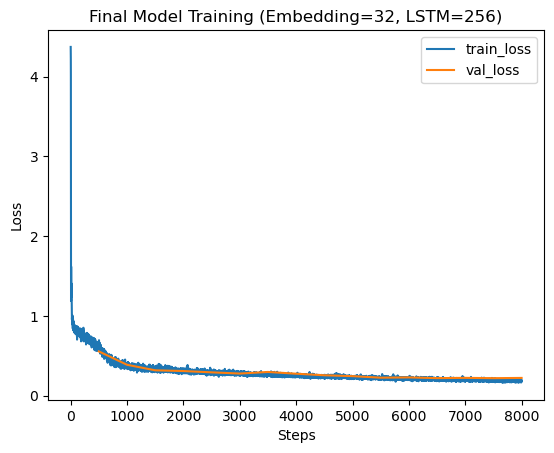

No Prefix:
 [None] Creature, Horsy Skeleton: Suntreast of the Nedrel
 [2] Artifact Creature, Construct: Sbillew Welder
 [5G] Creature, Efred: Skull Calamiy
 [3U] Creature, Dragon: Torc Wizar
 [5R] Creature, Beast: Axob Couzery

With [2U] prefix:
[2U] Instant: E.
[2U] Artalt, Eldrazi :riftskrouk Mawler
[2U] Instant: Aetherinds
[2U] Instant: Hinders
[2U] Instant: Pulson of Kit


In [101]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense

# -----------------------------
# 1) Hyperparameters & Data
# -----------------------------
EMBED_SIZE = 32
LSTM_UNITS = 256
LEARNING_RATE = 1e-3
N_STEPS = 8000  # or more, e.g. 10,000
BATCH_SIZE = 32
MAX_LENGTH = 169

# -----------------------------
# 2) Build Model in Single Graph
# -----------------------------
sess = tf.Session()
input_seq = tf.placeholder(tf.int32, [None, MAX_LENGTH], name="input_seq")

# Keras layers
embedding_layer = Embedding(n_tokens, EMBED_SIZE)
x_emb = embedding_layer(input_seq)  # shape: [batch_size, MAX_LENGTH, EMBED_SIZE]

# Two LSTM layers, each with return_sequences=True
x_lstm1 = LSTM(LSTM_UNITS, return_sequences=True)(x_emb)
x_lstm2 = LSTM(LSTM_UNITS, return_sequences=True)(x_lstm1)

# Final dense for logits
logits_3d_main = Dense(n_tokens)(x_lstm2)  # shape: [batch_size, MAX_LENGTH, n_tokens]

# For training, skip last time step
logits_3d_train = logits_3d_main[:, :-1, :]
targets_train = tf.reshape(input_seq[:, 1:], [-1])  # shift input by 1
max_len_minus_1 = tf.shape(logits_3d_train)[1]
batch_size_dyn = tf.shape(logits_3d_train)[0]
targets_train = targets_train[: batch_size_dyn * max_len_minus_1]

logits_2d_train = tf.reshape(logits_3d_train, [-1, n_tokens])
loss_per_timestep = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=targets_train,
    logits=logits_2d_train
)
loss_op = tf.reduce_mean(loss_per_timestep)

train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_op)

sess.run(tf.global_variables_initializer())

# -----------------------------
# 3) Training with Validation
# -----------------------------
train_history = []
val_history = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

def compute_validation_loss():
    batch_lines_val = random.sample(lines_val, BATCH_SIZE)
    X_val = to_matrix(batch_lines_val, max_len=MAX_LENGTH)
    return sess.run(loss_op, feed_dict={input_seq: X_val})

for step in range(N_STEPS):
    batch_lines_train = random.sample(lines_train, BATCH_SIZE)
    X_batch = to_matrix(batch_lines_train, max_len=MAX_LENGTH)
    
    train_loss_val, _ = sess.run([loss_op, train_op], feed_dict={input_seq: X_batch})
    train_history.append(train_loss_val)
    
    # Every 500 steps, check validation
    if (step + 1) % 500 == 0:
        val_loss_now = compute_validation_loss()
        val_history.append(val_loss_now)
        print(f"Step {step+1}/{N_STEPS}, Train loss={train_loss_val:.4f}, Val loss={val_loss_now:.4f}")
        
        if val_loss_now < best_val_loss:
            best_val_loss = val_loss_now
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training vs validation
plt.plot(train_history, label='train_loss')
x_vals = np.arange(499, len(train_history), 500)
plt.plot(x_vals, val_history, label='val_loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Final Model Training (Embedding=32, LSTM=256)")
plt.legend()
plt.show()

# -----------------------------
# 4) Iterative Generation
# -----------------------------
def iterative_generate_fixed_shape(
    seed_phrase=" ",
    max_length=60,
    temperature=1.0
):
    """
    We'll feed (1, MAX_LENGTH=169) each iteration, but only sample up to 'max_length'.
    """
    pad_id = token_to_id["#"]
    seed_ids = [token_to_id[ch] for ch in seed_phrase]
    
    if len(seed_ids) > MAX_LENGTH:
        raise ValueError("Seed phrase longer than 169.")
    
    # Prepare (1, 169)
    current_input = np.full((1, MAX_LENGTH), pad_id, dtype=np.int32)
    current_input[0, :len(seed_ids)] = seed_ids
    
    generated_ids = list(seed_ids)
    current_pos = len(seed_ids)
    
    while current_pos < max_length:
        logits_val = sess.run(logits_3d_main, feed_dict={input_seq: current_input})
        # shape: [1, 169, n_tokens]
        
        idx_for_logits = current_pos - 1 if current_pos > 0 else 0
        last_logits = logits_val[0, idx_for_logits, :]
        
        # Temperature
        last_logits /= temperature
        probs = np.exp(last_logits - np.max(last_logits))
        probs /= np.sum(probs)
        
        next_token_id = np.random.choice(range(n_tokens), p=probs)
        generated_ids.append(next_token_id)
        
        current_input[0, current_pos] = next_token_id
        current_pos += 1
    
    # Convert IDs -> chars, ignoring pad
    return ''.join(tokens[idx] for idx in generated_ids if tokens[idx] != "#")

# -----------------------------
# 5) Generate Samples
# -----------------------------
print("No Prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(seed_phrase=" ", max_length=60, temperature=1.0))

print("\nWith [2U] prefix:")
for _ in range(5):
    print(iterative_generate_fixed_shape(seed_phrase="[2U]", max_length=60, temperature=1.0))


In [104]:
def generate_from_user_input():
    """
    Prompts the user for a seed phrase (prefix).
    If user enters 'none' or an empty string, use a blank prefix for random text.
    Then generates a line using iterative_generate_fixed_shape with fixed max_length=60 and temperature=1.0.
    """
    user_seed = input("Enter your prefix (type 'none' or leave blank for random generation): ")
    # If user input is 'none' or empty, we treat it as blank space seed
    if not user_seed.strip() or user_seed.strip().lower() == 'none':
        user_seed = " "
    
    # Generate with fixed max_length=60 and temperature=1.0
    output_text = iterative_generate_fixed_shape(
        seed_phrase=user_seed,
        max_length=60,
        temperature=1.0
    )
    print(f"\nGenerated Text:\n{output_text}\n")

# Example usage (uncomment to run interactively):
generate_from_user_input()


Enter your prefix (type 'none' or leave blank for random generation):  



Generated Text:
 [U] Creature, Shapethister: Zainflame Inrentilor

